In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'month': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,incoming_bid_avg_sun,incoming_bid_avg_sbn,dpk_bankumum,dv_bankindonesia,vix_index,bfcius_bberg
date,,,,,,
2012-01-01,38.90175,38.901750,2770.57007,0,20.403182,-1.200591
2012-02-01,32.32425,18.457750,2763.94286,0,18.390000,-0.785571
2012-03-01,12.35250,8.043250,2825.97490,0,16.167273,-0.655591
2012-04-01,17.16300,11.396250,2841.36139,0,17.769524,-0.710952
2012-05-01,14.01525,8.320625,2908.95747,0,21.034783,-0.828000


In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [5]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 2012-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=114)
Test dates  : 2021-07-01 00:00:00 --- 2022-06-01 00:00:00  (n=12)


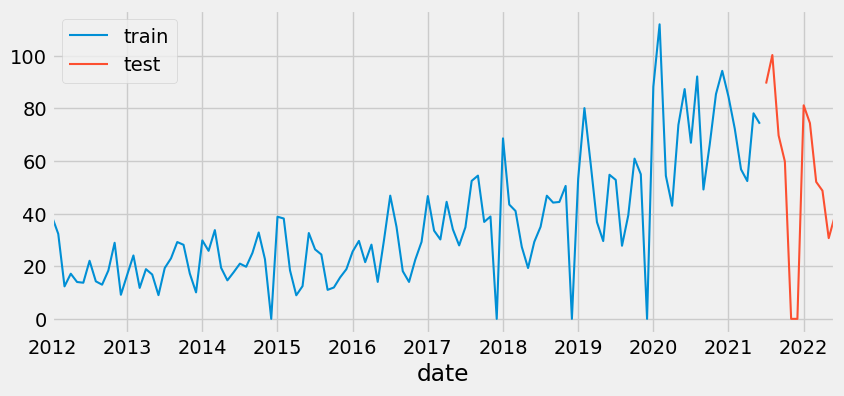

In [7]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['incoming_bid_avg_sun'].plot(ax=ax, label='train')
data_test['incoming_bid_avg_sun'].plot(ax=ax, label='test')
ax.legend();

In [9]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['incoming_bid_avg_sun'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2021-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 20:28:10 
Last fit date: 2023-01-27 20:28:10 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [10]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2021-07-01    77.109649
2021-08-01    73.458903
2021-09-01    65.830352
2021-10-01    62.866192
2021-11-01    76.437533
Freq: MS, Name: pred, dtype: float64

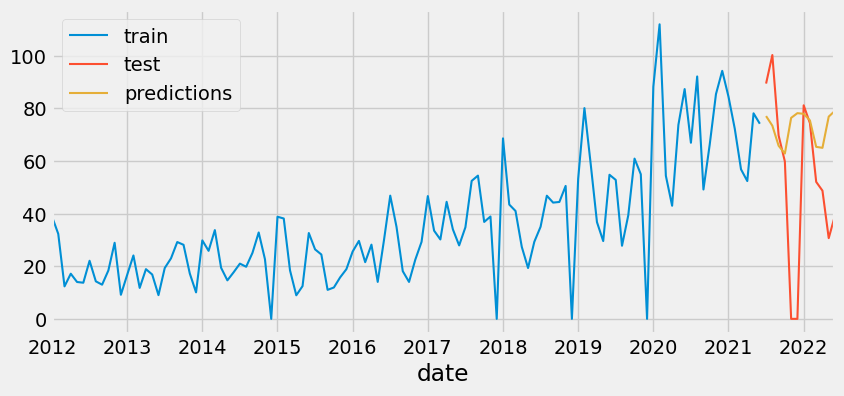

In [11]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['incoming_bid_avg_sun'].plot(ax=ax, label='train')
data_test['incoming_bid_avg_sun'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [12]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['incoming_bid_avg_sun'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1419.632553197437


In [21]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['incoming_bid_avg_sun'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:12<00:00,  6.34s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 459.26059397418294



In [22]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",459.260594,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",469.244466,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",473.567697,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",481.408551,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",485.328628,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",486.946480,3,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",555.188570,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",565.899482,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",568.228151,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",574.758681,5,100


In [23]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['incoming_bid_avg_sun'])

In [24]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

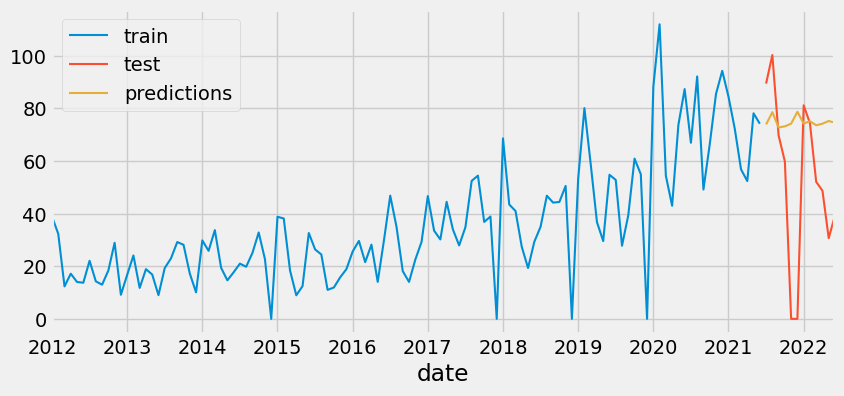

In [25]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['incoming_bid_avg_sun'].plot(ax=ax, label='train')
data_test['incoming_bid_avg_sun'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [26]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['incoming_bid_avg_sun'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1416.789709656867


In [27]:
# Backtesting
# ==============================================================================
steps = 12
n_backtesting = 12*3 # The last 3 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['incoming_bid_avg_sun'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2019-06-01 00:00:00  (n=90)
    Validation: 2019-07-01 00:00:00 -- 2020-06-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2020-06-01 00:00:00  (n=102)
    Validation: 2020-07-01 00:00:00 -- 2021-06-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2021-06-01 00:00:00  (n=114)
    Validation: 2021-07-01 00:00:00 -- 2022-06-01 00:00:00  (n=12)

Backtest error: 882.8907296421114


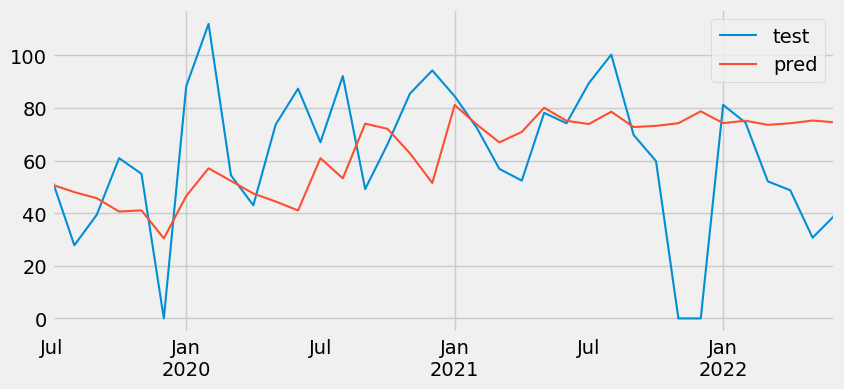

In [28]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions_backtest.index, 'incoming_bid_avg_sun'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [29]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.060538
1,lag_2,0.012834
2,lag_3,0.079185
3,lag_4,0.134285
4,lag_5,0.037754
5,lag_6,0.026895
6,lag_7,0.119625
7,lag_8,0.012753
8,lag_9,0.012532
9,lag_10,0.009073
